In [59]:
import numpy as np
import pandas as pd
import statistics
import matplotlib.pyplot as plt


from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report
from sklearn.utils import resample
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import KFold
from sklearn.metrics import accuracy_score
from sklearn import metrics
from sklearn.model_selection import cross_val_score

from model_testing_util import cross_validation
from load_data import load_heart_data, load_tweet_data

In [2]:
train_X, test_X, train_y, test_y = load_heart_data("heart_dataset.csv")

In [3]:
print("Shape of Train X: ", train_X.shape, ", Type: ", type(train_X))
print("Shape of Test X: ", test_X.shape, ", Type: ", type(test_X))
print("Shape of Train y: ", train_y.shape, ", Type: ", type(train_y))
print("Shape of Test y: ", test_y.shape, ", Type: ", type(test_y))

Shape of Train X:  (820, 13) , Type:  <class 'numpy.ndarray'>
Shape of Test X:  (205, 13) , Type:  <class 'numpy.ndarray'>
Shape of Train y:  (820,) , Type:  <class 'numpy.ndarray'>
Shape of Test y:  (205,) , Type:  <class 'numpy.ndarray'>


# Baseline Performance

Before testing out the new method explored in the project regarding the locally weighted trees, we will first test out the existing method we aim to improve upon, the random forest model.

In [4]:
# To find the best random forrest model, we need to tune the hyperparameters. Will do 
# so by performing a grid search 

grid_search_parameters = {'max_depth':[5, 10, 15, 30, 50, None], 
                          'n_estimators':[10, 25, 50, 100, 250, 500, 1000], 
                          'max_samples': [0.3, 0.5, 0.7, 0.8, 0.9, 1]}


In [16]:
random_forest_classifier = RandomForestClassifier(random_state=1)
random_forest_classifier_GS = GridSearchCV(random_forest_classifier, grid_search_parameters, cv=5, verbose=0)
random_forest_classifier_GS.fit(train_X, train_y)


GridSearchCV(cv=5, estimator=RandomForestClassifier(random_state=1),
             param_grid={'max_depth': [5, 10, 15, 30, 50, None],
                         'max_samples': [0.3, 0.5, 0.7, 0.8, 0.9, 1],
                         'n_estimators': [10, 25, 50, 100, 250, 500, 1000]})

In [17]:
print("Best Parameters: ", random_forest_classifier_GS.best_params_)
print("Best Score: ", random_forest_classifier_GS.best_score_)

Best Parameters:  {'max_depth': 10, 'max_samples': 0.7, 'n_estimators': 500}
Best Score:  0.9817073170731707


In [54]:
# Train the model with the best parameters:
random_forest_classifier = RandomForestClassifier(random_state=1, n_estimators=500, max_samples=0.7, max_depth=10)
random_forest_classifier.fit(train_X, train_y)
RF_predictions = random_forest_classifier.predict(test_X)

print(classification_report(test_y, RF_predictions, digits=5))

              precision    recall  f1-score   support

           0    1.00000   0.94444   0.97143       108
           1    0.94175   1.00000   0.97000        97

    accuracy                        0.97073       205
   macro avg    0.97087   0.97222   0.97071       205
weighted avg    0.97244   0.97073   0.97075       205



# Locally Weighted Random Forest

In [4]:
from locallyWeightedRandomForest import LocallyWeightedRandomForest
from sklearn.utils.estimator_checks import check_estimator

# Distance functions

In [5]:
def euclidean_distance(x_1:np.ndarray, x_2:np.ndarray) -> float:
    return np.linalg.norm(x_1 - x_2)

def manhattan_distance(x_1:np.ndarray, x_2:np.ndarray) -> float:
    return np.linalg.norm(x_1 - x_2, ord=1)

def cosine_similarity(x_1:np.ndarray, x_2:np.ndarray) -> float:
    return np.dot(x_1,x_2)/(np.linalg.norm(x_1)*np.linalg.norm(x_2))

def mean_distance(point:np.ndarray, dataset:np.ndarray, distance_function:callable = lambda a,b: 1)-> float:
    distance_sum = 0
    for p in dataset:
        distance_sum += distance_function(point, p)
    return distance_sum/len(dataset)

def distance_to_dataset_mean(point:np.ndarray, dataset:np.ndarray, distance_function:callable = lambda a,b: 1)-> float:
    mean_dataset_point = np.mean(dataset, axis=0)
    return distance_function(point, mean_dataset_point)

def median_distance(point:np.ndarray, dataset:np.ndarray, distance_function:callable = lambda a,b: 1)-> float:
    distances = []
    for p in dataset:
        distances.append(distance_function(point, p))
    return statistics.median(distances)

def nearest_k_distance_mean(k:int) -> callable:
    def _smallest_k_distances_mean(point:np.ndarray, dataset:np.ndarray, distance_function:callable = lambda a,b: 1) -> float:
        distances = np.zeros(len(dataset))
        for i in range(len(dataset)):
            distances[i] = distance_function(point, dataset[i])
        smallest_k_distaces = np.sort(distances)[:k]
        return np.mean(smallest_k_distaces, axis=0)

    return _smallest_k_distances_mean

### Best Performing LWRF

In [22]:

# To find the best locally weighted random forrest model, we need to tune the hyperparameters. Will do 
# so by performing a grid search 

grid_search_parameters = {'max_depth':[10, 30, 50], 
                          'n_estimators':[50, 100, 250, 500], 
                          'max_samples': [0.3, 0.5, 0.75, 1], 
                          'distance_function': [euclidean_distance, cosine_similarity], 
                          'distance_agg_func': [mean_distance, distance_to_dataset_mean, nearest_k_distance_mean(k=1), nearest_k_distance_mean(k=5)], 
                          'temp': [0.15, 0.5, 1] }


In [24]:
lwrf_GS = GridSearchCV(LocallyWeightedRandomForest(), grid_search_parameters, cv=5, verbose=3)
lwrf_GS.fit(train_X, train_y)


Fitting 5 folds for each of 1152 candidates, totalling 5760 fits
[CV 1/5] END distance_agg_func=<function mean_distance at 0x17a587250>, distance_function=<function euclidean_distance at 0x17a75c280>, max_depth=10, max_samples=0.3, n_estimators=50, temp=0.15;, score=0.951 total time=   0.3s
[CV 2/5] END distance_agg_func=<function mean_distance at 0x17a587250>, distance_function=<function euclidean_distance at 0x17a75c280>, max_depth=10, max_samples=0.3, n_estimators=50, temp=0.15;, score=0.963 total time=   0.2s
[CV 3/5] END distance_agg_func=<function mean_distance at 0x17a587250>, distance_function=<function euclidean_distance at 0x17a75c280>, max_depth=10, max_samples=0.3, n_estimators=50, temp=0.15;, score=0.957 total time=   0.2s
[CV 4/5] END distance_agg_func=<function mean_distance at 0x17a587250>, distance_function=<function euclidean_distance at 0x17a75c280>, max_depth=10, max_samples=0.3, n_estimators=50, temp=0.15;, score=0.921 total time=   0.2s
[CV 5/5] END distance_agg_f

GridSearchCV(cv=5, estimator=LocallyWeightedRandomForest(max_samples=1.0),
             param_grid={'distance_agg_func': [<function mean_distance at 0x17a587250>,
                                               <function distance_to_dataset_mean at 0x17a585ea0>,
                                               <function nearest_k_distance_mean.<locals>._smallest_k_distances_mean at 0x17b249ab0>,
                                               <function nearest_k_distance_mean.<locals>._smallest_k_distances_mean at 0x17b249bd0>],
                         'distance_function': [<function euclidean_distance at 0x17a75c280>,
                                               <function cosine_similarity at 0x17a72da20>],
                         'max_depth': [10, 30, 50],
                         'max_samples': [0.3, 0.5, 0.75, 1],
                         'n_estimators': [50, 100, 250, 500],
                         'temp': [0.15, 0.5, 1]},
             verbose=3)

In [25]:
print("Best Parameters: ", lwrf_GS.best_params_)
print("Best Score: ", lwrf_GS.best_score_)

Best Parameters:  {'distance_agg_func': <function nearest_k_distance_mean.<locals>._smallest_k_distances_mean at 0x17b249ab0>, 'distance_function': <function cosine_similarity at 0x17a72da20>, 'max_depth': 50, 'max_samples': 0.75, 'n_estimators': 100, 'temp': 0.15}
Best Score:  0.9853658536585368


In [92]:
# Train the model with the best parameters:
lwrf = LocallyWeightedRandomForest(n_estimators=100, temp=0.15, distance_aggregation_function=nearest_k_distance_mean(k=1), distance_function=cosine_similarity, max_depth=50, max_samples=0.75)
lwrf.fit(train_X, train_y)
lwrf_predictions = lwrf.predict(test_X)

print(classification_report(test_y, lwrf_predictions, digits=5))

              precision    recall  f1-score   support

           0    1.00000   0.97222   0.98592       108
           1    0.97000   1.00000   0.98477        97

    accuracy                        0.98537       205
   macro avg    0.98500   0.98611   0.98534       205
weighted avg    0.98580   0.98537   0.98537       205



In [93]:
lwrf_prob = lwrf.predict_proba(test_X)
fpr, tpr, _ = metrics.roc_curve(test_y, lwrf_prob[:, 1])
print("AUC = ", metrics.auc(fpr, tpr)) 

AUC =  0.9994272623138603


In [57]:
# Count the number of points that changes from the RF prediction to LWRF
print("True values: ", test_y[lwrf_predictions != RF_predictions])
print("LWRF values: ", lwrf_predictions[lwrf_predictions != RF_predictions])
print("RF values: ", RF_predictions[lwrf_predictions != RF_predictions])

True values:  [0 0 0]
LWRF values:  [0. 0. 0.]
RF values:  [1 1 1]


# Experiments

### Comparing sample sizes vs performance 

For this graph, we will keep the number of estimators constant at 100. 

In [ ]:
# For the random forest, we will try various values for the portion of the population we 
# sample the data from 
sample_sizes = np.arange(0.1, 1.01, 0.1)

euc_distance_acc = []
manhat_distance_acc = []
cos_distance_acc = []
random_forest_acc = []

for size in sample_sizes:
    euc_model=LocallyWeightedRandomForest(n_estimators=100, 
                                        temp=0.15, 
                                        distance_aggregation_function=nearest_k_distance_mean(k=1), 
                                        distance_function=euclidean_distance, 
                                        max_depth=50, 
                                        max_samples=size)
                                        
    euc_distance_acc.append(np.mean(cross_val_score(euc_model, train_X, train_y, cv=5, n_jobs=-1, verbose=2)))


    manh_model=LocallyWeightedRandomForest(n_estimators=100, 
                                        temp=0.15, 
                                        distance_aggregation_function=nearest_k_distance_mean(k=1), 
                                        distance_function=manhattan_distance, 
                                        max_depth=25, 
                                        max_samples=size)
                                        
    manhat_distance_acc.append(np.mean(cross_val_score(manh_model, train_X, train_y, cv=5, n_jobs=-1, verbose=2)))


    cos_model=LocallyWeightedRandomForest(n_estimators=100, 
                                        temp=0.15, 
                                        distance_aggregation_function=nearest_k_distance_mean(k=1), 
                                        distance_function=cosine_similarity, 
                                        max_depth=25, 
                                        max_samples=size)
                                        
    cos_distance_acc.append(np.mean(cross_val_score(cos_model, train_X, train_y, cv=5, n_jobs=-1, verbose=2)))

    rf_model=RandomForestClassifier(random_state=1, 
                                    n_estimators=100, 
                                    max_depth=25, 
                                    max_samples=size)
                                        
    random_forest_acc.append(np.mean(cross_val_score(rf_model, train_X, train_y, cv=5, n_jobs=-1, verbose=2)))


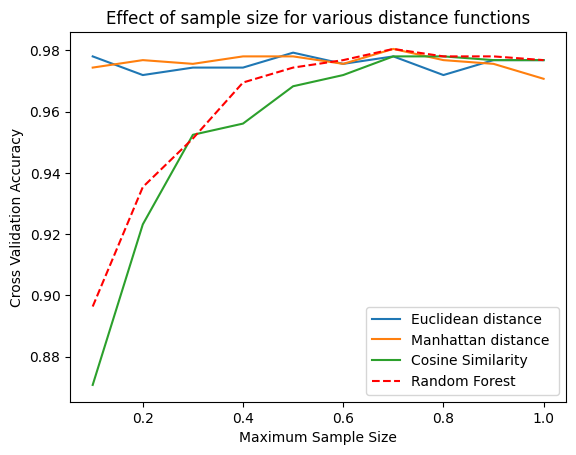

In [97]:
plt.title('Effect of sample size for various distance functions')



plt.plot(sample_sizes, euc_distance_acc,  label = "Euclidean distance")
plt.plot(sample_sizes,manhat_distance_acc, label = "Manhattan distance ")
plt.plot(sample_sizes,cos_distance_acc, label = "Cosine Similarity")
plt.plot(sample_sizes,random_forest_acc, color = 'r',linestyle = '--',  label = "Random Forest")

plt.xlabel('Maximum Sample Size')
plt.ylabel('Cross Validation Accuracy')

plt.legend()
plt.show()

### Other Model Performance

In [ ]:
from sklearn import metrics

KNN Model 

In [ ]:
from sklearn.neighbors import KNeighborsClassifier

In [ ]:
grid_search_parameters = {'n_neighbors':[2, 5, 8, 10,15,25]}

KNN = KNeighborsClassifier()
KNN_classifier_GS = GridSearchCV(KNN, grid_search_parameters, cv=5, verbose=0)
KNN_classifier_GS.fit(train_X, train_y)

print("Best Parameters: ", KNN_classifier_GS.best_params_)
print("Best Score: ", KNN_classifier_GS.best_score_)

Best Parameters:  {'n_neighbors': 2}
Best Score:  0.9414634146341463


In [ ]:
# Train the model with the best parameters:
KNN_classifier = KNeighborsClassifier(n_neighbors=2)
KNN_classifier.fit(train_X, train_y)
predictions = KNN_classifier.predict(test_X)

print(classification_report(test_y, predictions, digits=5))

              precision    recall  f1-score   support

           0    0.98131   0.97222   0.97674       108
           1    0.96939   0.97938   0.97436        97

    accuracy                        0.97561       205
   macro avg    0.97535   0.97580   0.97555       205
weighted avg    0.97567   0.97561   0.97562       205



In [ ]:
knn_prob = KNN_classifier.predict_proba(test_X)
fpr, tpr, _ = metrics.roc_curve(test_y, knn_prob[:, 1])
print("AUC = ", metrics.auc(fpr, tpr)) 

AUC =  0.9844883543337152


### SVM

In [ ]:
from sklearn.svm import SVC

grid_search_parameters = {'kernel': ['linear', 'poly', 'rbf', 'sigmoid'], 
                          'C': [0.25,0.5,1,2,3,5],
                          'gamma': [0.1, 1, 'scale', 'auto']}
                          
#Using LibLinear to allow for both l1 and l2 loss in grid search 
svm = SVC()
svm_GS = GridSearchCV(svm, grid_search_parameters, cv=5, verbose=0)
svm_GS.fit(train_X, train_y)

print("Best Parameters: ", svm_GS.best_params_)
print("Best Score: ", svm_GS.best_score_)

Best Parameters:  {'C': 5, 'gamma': 0.1, 'kernel': 'poly'}
Best Score:  0.9707317073170731


In [ ]:
# Train the model with the best parameters:
SVM_classifier = SVC(C=1, gamma=0.1, kernel='rbf', probability=True)
SVM_classifier.fit(train_X, train_y)
predictions = SVM_classifier.predict(test_X)

print(classification_report(test_y, predictions, digits=5))

              precision    recall  f1-score   support

           0    0.95238   0.92593   0.93897       108
           1    0.92000   0.94845   0.93401        97

    accuracy                        0.93659       205
   macro avg    0.93619   0.93719   0.93649       205
weighted avg    0.93706   0.93659   0.93662       205



In [ ]:
svm_prob = SVM_classifier.predict_proba(test_X)
fpr, tpr, _ = metrics.roc_curve(test_y, svm_prob[:, 1])
print("AUC = ", metrics.auc(fpr, tpr)) 

AUC =  0.9572355861015654


### Logistic Regression

In [ ]:
from sklearn.linear_model import LogisticRegression
grid_search_parameters = {'penalty':['l2', 'l1'], 
                          'C': [0.25,0.5,1,2,3,5]}
                          
#Using LibLinear to allow for both l1 and l2 loss in grid search 
LR = LogisticRegression(solver='liblinear')
LogisticRegression_GS = GridSearchCV(LR, grid_search_parameters, cv=5, verbose=0)
LogisticRegression_GS.fit(train_X, train_y)

print("Best Parameters: ", LogisticRegression_GS.best_params_)
print("Best Score: ", LogisticRegression_GS.best_score_)

Best Parameters:  {'C': 1, 'penalty': 'l1'}
Best Score:  0.8512195121951219


In [ ]:
# Train the model with the best parameters:
LR_classifier = LogisticRegression(solver='liblinear', C=1, penalty='l1')
LR_classifier.fit(train_X, train_y)
predictions = LR_classifier.predict(test_X)

print(classification_report(test_y, predictions, digits=5))

              precision    recall  f1-score   support

           0    0.91489   0.79630   0.85149       108
           1    0.80180   0.91753   0.85577        97

    accuracy                        0.85366       205
   macro avg    0.85835   0.85691   0.85363       205
weighted avg    0.86138   0.85366   0.85351       205



In [ ]:
LR_prob = LR_classifier.predict_proba(test_X)
fpr, tpr, _ = metrics.roc_curve(test_y, LR_prob[:, 1])
print("AUC = ", metrics.auc(fpr, tpr)) 

AUC =  0.9080756013745706
